In [4]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K

(210, 160, 3)


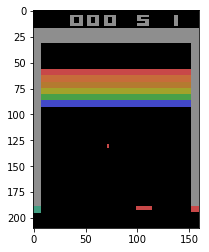

In [5]:
env = gym.make('BreakoutDeterministic-v4')
observation = env.reset()

for i in range(3):
    # The ball is released after 2 frames
    if i > 1:
        print(observation.shape)
        plt.imshow(observation)
        plt.show()
        
    # Get the next observation
    observation, _, _, _ = env.step(1)

In [6]:
def preprocess_frame(frame):
    frame = frame[30:200, 10:150]
    
    # grayscale frame and downsize by factor 2
    frame = frame[::2, ::2, 0]
    
    # set background to 0
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    
    # set ball and paddles to 1
    frame[frame != 0] = 1
    
    return frame

(85, 70)


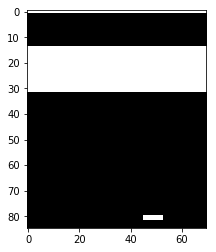

In [22]:
obs_preprocessed = preprocess_frame(observation)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

In [37]:
class DQLAgent:
    def __init__(self, cols, rows, n_actions, batch_size=32):
        self.state_size = (cols, rows, 4)
        self.n_actions = n_actions
        self.epsilon = 1.
        self.epsilon_start, self.epsilon_end = 1.0, 0.1
        self.exploration_steps = 1000000.
        self.epsilon_decay_step = (self.epsilon_start - self.epsilon_end) / self.exploration_steps
        self.batch_size = batch_size
        self.discount_factor = 0.99
        self.memory = deque(maxlen=400000)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.optimizer = self.optimizer()
        self.avg_q_max, self.avg_loss = 0, 0

    def optimizer(self):
        a = K.placeholder(shape=(None,), dtype='int32')
        y = K.placeholder(shape=(None,), dtype='float32')

        py_x = self.model.output

        a_one_hot = K.one_hot(a, self.n_actions)
        q_value = K.sum(py_x * a_one_hot, axis=1)
        error = K.abs(y - q_value)

        quadratic_part = K.clip(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = K.mean(0.5 * K.square(quadratic_part) + linear_part)

        opt = Adam(lr=0.00025, epsilon=0.01)
        updates = opt.get_updates(self.model.trainable_weights, [], loss)
        train = K.function([self.model.input, a, y], [loss], updates=updates)

        return train

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.n_actions))
        model.summary()
        return model

    def update_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def action(self, history):
        history = np.float32(history / 255.0)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        else:
            q_value = self.model.predict(history)
            return np.argmax(q_value[0])

    def replay(self, history, action, reward, next_history, dead):
        self.memory.append((history, action, reward, next_history, dead))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_step

        mini_batch = random.sample(self.memory, self.batch_size)
        history = np.zeros((self.batch_size, self.state_size[0], self.state_size[1], self.state_size[2]))
        next_history = np.zeros((self.batch_size, self.state_size[0], self.state_size[1], self.state_size[2]))
        target = np.zeros((self.batch_size,))
        action, reward, dead = [], [], []

        for i in range(self.batch_size):
            history[i] = np.float32(mini_batch[i][0] / 255.)
            next_history[i] = np.float32(mini_batch[i][3] / 255.)
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            dead.append(mini_batch[i][4])

        target_value = self.target_model.predict(next_history)

        for i in range(self.batch_size):
            if dead[i]:
                target[i] = reward[i]
            else:
                target[i] = reward[i] + self.discount_factor * \
                                        np.amax(target_value[i])

        loss = self.optimizer([history, action, target])
        self.avg_loss += loss[0]

In [38]:
env = gym.make('BreakoutDeterministic-v4')

# General settings
n_warmup_steps = 50000
update_model_rate = 10000
cols, rows = 85, 70
n_states = 4

# Hyperparameters
batch_size = 32

# Initialization
agent = DQLAgent(cols, rows, n_actions=3)
scores, episodes = [], []
n_steps = 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 20, 16, 32)        8224      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 9, 7, 64)          32832     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 7, 5, 64)          36928     
_________________________________________________________________
flatten_18 (Flatten)         (None, 2240)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               1147392   
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 1539      
Total params: 1,226,915
Trainable params: 1,226,915
Non-trainable params: 0
_________________________________________________________________


In [ ]:
while True:
    done = False
    dead = False
    step, score, start_life = 0, 0, 5
    observation = env.reset()


    state = preprocess_frame(observation, cols, rows)
    history = np.stack((state, state, state, state), axis=2)
    history = np.reshape([history], (1, cols, rows, n_states))

    while not done:
#         env.render()
        n_steps += 1
        step += 1
        
        # Get action
        action = agent.action(history)
        observation, reward, done, info = env.step(action+1)
        
        # Extract next state
        state_next = preprocess_frame(observation, cols, rows)
        state_next = np.reshape([state_next], (1, cols, rows, 1))
        history_next = np.append(state_next, history[:, :, :, :3], axis=3)

        agent.avg_q_max += np.amax(agent.model.predict(history)[0])
        reward = np.clip(reward, -1., 1.)

        agent.replay(history, action, reward, history_next, dead)
        agent.train()
        if n_steps % update_model_rate == 0:
            agent.update_model()
        score += reward

        if dead:
            dead = False
        else:
            history = history_next

        if done:
            print('episode {:2d}; score: {:2.0f}; q {:2f}; loss {:2f}; steps {}'
                  .format(n_steps, score, agent.avg_q_max / float(step), agent.avg_loss / float(step), step))

            agent.avg_q_max, agent.avg_loss = 0, 0
    
    # Save weights of model
    if n_steps % 1000 == 0:
        agent.model.save_weights("breakout_dql.h5")

episode 38184; score:  1; q 0.103984; loss 0.003715; steps 184
episode 38344; score:  1; q 0.104243; loss 0.002910; steps 160
episode 38472; score:  0; q 0.103152; loss 0.002797; steps 128
episode 38655; score:  2; q 0.096552; loss 0.002553; steps 183
episode 38910; score:  3; q 0.107148; loss 0.003168; steps 255
episode 39096; score:  1; q 0.104453; loss 0.003673; steps 186
episode 39223; score:  0; q 0.105251; loss 0.003306; steps 127
episode 39430; score:  2; q 0.107592; loss 0.003523; steps 207
episode 39620; score:  2; q 0.097023; loss 0.003680; steps 190
episode 39744; score:  0; q 0.105037; loss 0.003634; steps 124
episode 39875; score:  0; q 0.105331; loss 0.003324; steps 131
episode 40008; score:  0; q 0.104414; loss 0.003160; steps 133
episode 40183; score:  1; q 0.118197; loss 0.003377; steps 175
episode 40309; score:  0; q 0.113409; loss 0.002717; steps 126
episode 40515; score:  2; q 0.122965; loss 0.003545; steps 206
episode 40675; score:  1; q 0.115003; loss 0.002720; st

episode 62359; score:  2; q 0.180672; loss 0.003142; steps 203
episode 62532; score:  1; q 0.182324; loss 0.002612; steps 173
episode 62699; score:  1; q 0.179419; loss 0.003816; steps 167
episode 62951; score:  3; q 0.183398; loss 0.003027; steps 252
episode 63079; score:  0; q 0.181263; loss 0.003279; steps 128
episode 63263; score:  1; q 0.187231; loss 0.003716; steps 184
episode 63398; score:  0; q 0.183893; loss 0.002999; steps 135
episode 63641; score:  3; q 0.183360; loss 0.003266; steps 243
episode 63829; score:  1; q 0.189162; loss 0.003227; steps 188
episode 63986; score:  1; q 0.183909; loss 0.003170; steps 157
episode 64188; score:  2; q 0.188075; loss 0.003002; steps 202
episode 64350; score:  1; q 0.185364; loss 0.003077; steps 162
episode 64563; score:  2; q 0.191257; loss 0.003571; steps 213
episode 64742; score:  1; q 0.192604; loss 0.003390; steps 179
episode 64998; score:  3; q 0.184840; loss 0.002556; steps 256
episode 65142; score:  0; q 0.190612; loss 0.003351; st

episode 86636; score:  0; q 0.272953; loss 0.002659; steps 129
episode 86885; score:  3; q 0.278167; loss 0.003685; steps 249
episode 87177; score:  3; q 0.274800; loss 0.003730; steps 292
episode 87311; score:  0; q 0.274315; loss 0.002907; steps 134
episode 87448; score:  0; q 0.276048; loss 0.002846; steps 137
episode 87580; score:  0; q 0.275022; loss 0.004354; steps 132
episode 87735; score:  1; q 0.279772; loss 0.003910; steps 155
episode 87912; score:  1; q 0.282146; loss 0.002903; steps 177
episode 88126; score:  2; q 0.279852; loss 0.003777; steps 214
episode 88305; score:  1; q 0.276299; loss 0.003047; steps 179
episode 88440; score:  0; q 0.280466; loss 0.003915; steps 135
episode 88674; score:  2; q 0.284861; loss 0.003657; steps 234
episode 88863; score:  1; q 0.276750; loss 0.003617; steps 189
episode 89052; score:  2; q 0.265429; loss 0.002885; steps 189
episode 89254; score:  2; q 0.280308; loss 0.002779; steps 202
episode 89468; score:  2; q 0.284689; loss 0.003416; st

In [ ]:
env = gym.make('BreakoutDeterministic-v4')
agent = DQLAgent(cols, rows, n_action=3)

for i in range(5):
    observation = env.reset()

    state = pre_processing(observation, cols, rows)
    history = np.stack((state, state, state, state), axis=2)
    history = np.reshape([history], (1, cols, rows, n_states))

    while not done:
        env.render()
        action = agent.get_action(history)
        observe, reward, done, info = env.step(action+1)